### **Introduction to Arachne**
Arachne is a Python package for graph analysis that is built as an extension to Arkouda, a Python package for analysis on tabular data, akin to NumPy and Pandas. In this notebook we will show examples on how to run each algorithm that has been implemented on different types of graphs: undirected, directed, and property.

In [3]:
import arkouda as ak
import arachne as ar
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import os

In [4]:
# NOTE: Make sure to change the server name to whatever is applicable in your environment. If running locally, then use only ak.connect().
ak.connect("n85", 5555)

connected to arkouda server tcp://*:5555


### **Graph Generation and Loading**
Graphs can be built from existing data or generated with our suite of random graph generators. The preferred way to load a graph into memory is from Arkouda arrays, however we provide a method to read a graph in from matrix market format or randomly generate some graphs.

In [5]:
# Read in a graph from a matrix market file.
absolute_path_to_karate = os.path.abspath("data/karate.mtx")
karate = ar.read_matrix_market_file(absolute_path_to_karate)

In [6]:
# Generate a random graph using any variety of random generators available.
n = 100
rmat_graph = ar.rmat(15, create_using=ar.Graph)
gnp_graph = ar.gnp(n, 0.75, create_using=ar.Graph)
rtree_graph = ar.random_tree(n, create_using=ar.Graph)
ws_graph = ar.watts_strogatz_graph(n, 25, 0.56, create_using=ar.Graph)
graph_list = [rmat_graph, gnp_graph, rtree_graph, ws_graph]
for g in graph_list:
    print(f"Generated graph has {len(g)} vertices and {g.size()} edges")

Generated graph has 24273 vertices and 442026 edges
Generated graph has 100 vertices and 2636 edges
Generated graph has 100 vertices and 100 edges
Generated graph has 100 vertices and 2000 edges


In [7]:
# Create a property graph from Arkouda dataframes, usually read in from HDF5, Parquet, or CSV files. For demonstrative purposes, we create some random dataset here.
n = 1_000           # Number of vertices.
m = 1_000_000       # Number of edges.
k = 2               # Value to cap the randomness at.

In [8]:
# Create variously different random arrays of different types: integers, unsigned integers, floats, booleans, strings, and categoricals.
src_array = ak.randint(0, n, m, dtype=ak.dtype('int64'), seed=2)
dst_array = ak.randint(0, n, m, dtype=ak.dtype('int64'), seed=4)
int_array = ak.randint(-1, k, m, dtype=ak.dtype('int64'), seed=6)
uint_array = ak.randint(0, k, m, dtype=ak.dtype('uint64'), seed=8)
real_array = ak.randint(0, k, m, dtype=ak.dtype('float64'), seed=10)
bool_array = ak.randint(0, k, m, dtype=ak.dtype('bool'), seed=12)
strings_array = ak.random_strings_uniform(0, k, m, characters="abcdefghijklmonpqrstuvwxyz", seed=14)
categorical_array = ak.Categorical(ak.random_strings_uniform(0, k, m, characters="abcdefghijklmonpqrstuvwxyz", seed=14))

In [9]:
# Initialize an empty graph object.
prop_graph = ar.PropGraph()

In [10]:
# Create a dataframe with the edge data.
test_edge_dict = {
    "src":src_array,
    "dst":dst_array,
    "data1":int_array,
    "data2":uint_array,
    "data3":real_array,
    "data4":bool_array,
    "data5":strings_array,
    "data6":categorical_array
}
test_edge_df = ak.DataFrame(test_edge_dict)

In [11]:
test_edge_df

,src,dst,data1,data2,data3,data4,data5,data6
0,351,671,0,0,0.638154,False,B,B
1,278,71,0,0,1.366654,False,L,L
2,828,401,0,1,0.887981,True,N,N
3,358,706,-1,0,1.219599,False,,
4,681,898,1,0,1.191131,True,Q,Q
...,...,...,...,...,...,...,...,...
999995,619,263,1,0,1.663987,False,,
999996,927,756,-1,0,0.781876,True,I,I
999997,63,449,1,0,1.614944,False,,
999998,938,493,1,0,0.226886,True,,


In [12]:
# Load in the edge attributes, with sorts the edges and handles storing their data.
prop_graph.load_edge_attributes(test_edge_df, source_column="src", destination_column="dst", relationship_columns=["data5", "data1"])

In [13]:
# Create sizes for vertex information.
m = len(prop_graph)
k = 2

In [14]:
# Create data of different types for vertices.
int_array = ak.randint(-1, k, m, dtype=ak.dtype('int64'), seed=6)
uint_array = ak.randint(0, k, m, dtype=ak.dtype('uint64'), seed=8)
real_array = ak.randint(0, k, m, dtype=ak.dtype('float64'), seed=10)
bool_array = ak.randint(0, k, m, dtype=ak.dtype('bool'), seed=12)
strings_array = ak.random_strings_uniform(0, k, m, characters="abcdefghijklmonpqrstuvwxyz", seed=14)
categorical_array = ak.Categorical(ak.random_strings_uniform(0, k, m, characters="abcdefghijklmonpqrstuvwxyz", seed=14))

In [15]:
# Create a dataframe with vertex data.
test_node_dict = {
    "nodes":prop_graph.nodes(),
    "data1":int_array,
    "data2":uint_array,
    "data3":real_array,
    "data4":bool_array,
    "data5":strings_array,
    "data6":categorical_array
}
test_node_df = ak.DataFrame(test_node_dict)

In [16]:
test_node_df

,nodes,data1,data2,data3,data4,data5,data6
0,0,0,0,0.638154,False,B,B
1,1,0,0,1.366654,False,L,L
2,2,0,1,0.887981,True,N,N
3,3,-1,0,1.219599,False,,
4,4,1,0,1.191131,True,Q,Q
...,...,...,...,...,...,...,...
995,995,1,1,0.253123,False,,
996,996,-1,1,0.924143,True,B,B
997,997,0,1,1.303909,False,,
998,998,-1,0,1.732572,True,,


In [17]:
# Load in the vertex data.
prop_graph.load_node_attributes(test_node_df, node_column="nodes", label_columns=["data5", "data2"])

### **Graph Processing and Querying**
Treating the graphs as dataframes allows us to exploit Arkouda's array searches to generate subgraphs in seconds.

In [18]:
# Create filters for vertices.
def node_filter(node_attributes):
    return node_attributes["data2"] == 0

In [19]:
# Create filters for edges.
def edge_filter(edge_attributes):
    return edge_attributes["data1"] > -1

In [20]:
# Create different subgraphs from each demo and together.
subgraph_nodes = prop_graph.subgraph_view(filter_node=node_filter)
print(f"Subgraph generated with edge size: {subgraph_nodes.size()}")
subgraph_edges = prop_graph.subgraph_view(filter_edge=edge_filter)
print(f"Subgraph generated with edge size: {subgraph_edges.size()}")
subgraph_together = prop_graph.subgraph_view(filter_node=node_filter, filter_edge=edge_filter)
print(f"Subgraph generated with edge size: {subgraph_together.size()}")

Subgraph generated with edge size: 467134
Subgraph generated with edge size: 420930
Subgraph generated with edge size: 100891


### **Graph Algorithms**
Let's now revisit the karate graph from above and do some analyses with Arachne and NetworkX together! First, let's start out by reading the matrix market file again, both with Arachne and NetworkX.

In [21]:
# First, let's build the graph with Arachne.
filepath = os.path.abspath("data/karate.mtx")
G = ar.read_matrix_market_file(filepath)

edge_src, edge_dst = G.edges()
edge_src = edge_src.to_list()
edge_dst = edge_dst.to_list()
edge_list = []
for (u,v) in zip(edge_src,edge_dst):
    edge_list.append((u,v))
nodes = G.nodes()

In [22]:
# Secondly, let's build the graph with NetworkX. NOTE: Arachne has a direct read_matrix_market_file method whereas NetworkX requires you to use SciPy to read in the matrix market file.
fh = open(filepath, "rb")
H = nx.from_scipy_sparse_array(sp.io.mmread(fh))
print(f"Let's make sure that both graphs have the same number of vertices and edges. Arachne graph has {len(G)} vertices and {G.size()} edges. NetworkX has {len(H)} vertices and {H.size()} edges.")

Let's make sure that both graphs have the same number of vertices and edges. Arachne graph has 34 vertices and 78 edges. NetworkX has 34 vertices and 78 edges.


We are also able to display our graph with NetworkX methods by exporting our edgelist and building a graph from the edges stored by Arachne. **Note: Visualization is resource-intensive, so you can really only do it for small graphs. However, we perform these steps to show how Arachne can complement NetworkX and how graphs can be exchanged between them.**

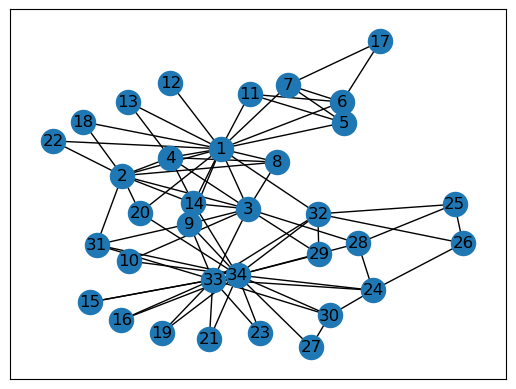

In [23]:
nx_display = nx.Graph()
nx_display.add_edges_from(edge_list)

pos = nx.kamada_kawai_layout(nx_display)
nx.draw_networkx(nx_display, pos, with_labels=True)
plt.show()

Below we also see how we can extract a degree view for a graph to see the dispersion of degrees amongst the vertices. This also works for directed graphs by using the `G.in_degree()` and `G.out_degree()` methods.

In [24]:
degrees = G.degree()
print(degrees)

[16 9 10 6 3 4 4 4 5 2 3 1 2 5 2 2 2 2 2 3 2 2 2 5 3 3 2 4 3 4 4 6 12 17]


Using Arkouda arrays we can also extract the node with maximum degree.

In [25]:
print(f"Node {G.nodes()[ak.argmax(degrees)]} has maximum degree of {ak.max(degrees)}")

Node 34 has maximum degree of 17


### **Breadth-First Search**

Given a graph $G$ (as defined above) and a source vertex $s$, breadth-first search (BFS) traverses the graph in a level-centric manner. It can return the tree inherently generated during BFS, the vertices found at each layer, or an ordering of nodes as predecessors or successors. For our implementation we opted to mimic NetworkX's `bfs_layers` function that returns the nodes and the layer they belong to.

Our BFS method, written in Chapel, expands the next frontier in parallel on each locale, if it is run on a distributed cluster. Each locale iterates over the frontier, and if there are any local edges, it inspects the neighbors, and if not yet visited, updates the `depth` (layer) pdarray. The final `depth` array is returned which can be used to provide a different view of a graph.

In [26]:
d = ar.bfs_layers(G, 1)
print(d)

[0 1 1 1 1 1 1 1 1 2 1 1 1 1 3 3 2 1 3 1 3 1 3 3 2 2 3 2 2 3 2 1 2 2]


We may also extract a histogram of the sizes of each level computed by BFS. This can be a useful manner in seeing how how big each group of vertices at a particular level is.

In [27]:
d_histogram = ak.histogram(d, bins=ak.max(d)+1)
print(d_histogram[0])

[1 16 9 8]


From the above we can see that at level 0 we obviously only have one vertex. Then, we can see that at level 1 we have 16, level 2 we have 9, and level 3 we have 8. The maximum level is 3. What happens if we change the source vertex? Let's see the results of bfs_layers for each vertex.

In [28]:
for i in range(1,len(G)+1):
    d = ar.bfs_layers(G, i)
    d_histogram = ak.histogram(d, bins=ak.max(d)+1)
    print(f"Size of breadth-first search layers for vertex {i}: {d_histogram[0]}")

Size of breadth-first search layers for vertex 1: [1 16 9 8]
Size of breadth-first search layers for vertex 2: [1 9 13 11]
Size of breadth-first search layers for vertex 3: [1 10 20 3]
Size of breadth-first search layers for vertex 4: [1 6 16 11]
Size of breadth-first search layers for vertex 5: [1 3 14 8 8]
Size of breadth-first search layers for vertex 6: [1 4 13 8 8]
Size of breadth-first search layers for vertex 7: [1 4 13 8 8]
Size of breadth-first search layers for vertex 8: [1 4 17 11 1]
Size of breadth-first search layers for vertex 9: [1 5 25 3]
Size of breadth-first search layers for vertex 10: [1 2 20 10 1]
Size of breadth-first search layers for vertex 11: [1 3 14 8 8]
Size of breadth-first search layers for vertex 12: [1 1 15 9 8]
Size of breadth-first search layers for vertex 13: [1 2 14 9 8]
Size of breadth-first search layers for vertex 14: [1 5 25 3]
Size of breadth-first search layers for vertex 15: [1 2 16 6 8 1]
Size of breadth-first search layers for vertex 16: [1 

From the output above we notice some main things:
1. Starting BFS from different sources arise to different number of layers for the output of each vertex.
2. Some nodes have the same number of vertices at each layer. 
3. Vertex 19 provides the largest number of layers for any of the vertices. 

Let's color the nodes for node 19 and show the output.

[3 3 2 3 4 4 4 3 2 2 4 4 4 2 2 2 5 4 0 2 2 4 2 2 3 3 2 2 2 2 2 2 1 1]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 18, 20, 22, 32, 31, 10, 28, 29, 33, 17, 34, 15, 16, 19, 21, 23, 24, 26, 30, 25, 27]


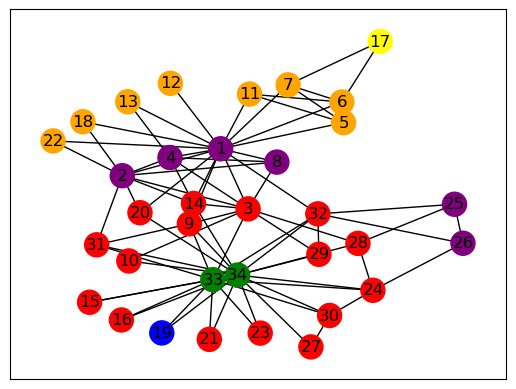

degrees = [16 9 10 6 3 4 4 4 5 2 3 1 2 5 2 2 2 2 2 3 2 2 2 5 3 3 2 4 3 4 4 6 12 17]


In [29]:
d = ar.bfs_layers(G, 19)
color_dict = {0:"blue", 1:"green", 2:"red", 3:"purple", 4:"orange", 5:"yellow"}
print(d)

color_map = []
nodes = nx_display.nodes()
for u in nodes:
    color_map.append(color_dict[d[u-1]])
    
print(nx_display.nodes)

pos = nx.kamada_kawai_layout(nx_display)
nx.draw_networkx(nx_display, pos, with_labels=True, node_color=color_map)
plt.show()

print(f"degrees = {degrees}")

In the returned image we can see the first frontier are the green vertices $<0, 1, 33>$. If we look at the degree view of the graph we notice that 0, 1, and 33 are in the top 4 of vertices with most degree, which now makes sense why vertex 19 had the largest expanded frontier. 

### **Connected Components**

Given a graph G, (as defined above) if there is a path from a vertex $u$ to every other vertex $v$ then the graph is said to be connected. If there is not a path, then the graph is said to be disconnected and composed of multiple connected components. There may be a large number of connected components of varying sizes in a graph.

One of the most ancient manners of calculating connected components involve running BFS until every vertex has been visited, at every iteration looking for the node whose value `-1` and start BFS from it. These steps are repeated until all the vertices have been labeled. The other is using union-find to build a tree induced by each connected component. For our method we use a lbel propagation technique that sends the minimum vertex label to all the other vertices in a connected component.

To run our connected components, you just have to call the `connected_components()` method. **We use one of the randomly generated graphs above for this example**.

In [30]:
cc = ar.connected_components(rmat_graph)
print(cc)

/scratch/users/oaa9/arkouda/arkouda/alignment.py:248: UserWarning: Duplicate terms present in search space. Only first instance of each query term will be reported. To return all occurrences, set all_occurrences=True.
  warn(


[0 0 0 ... 0 0 0]


We can use Arkouda methods to get the size of each component in our file. This will let us know which vertices will be included in the induced subgraph of the largest component.

In [31]:
g = ak.GroupBy(cc)
keys, count = g.size()
label_of_largest_component = ak.argmax(count)
label_of_smallest_component = ak.argmin(count)
print(f"The largest component is labeled: {keys[label_of_largest_component]}")
print(f"The smallest component is labeled: {keys[label_of_smallest_component]}")

The largest component is labeled: 0
The smallest component is labeled: 6975


### **Triangle Counting**
One of the most basic community structures that can be found in graphs are triangles. Triangles are 3-cliques in an undirected graph which means three nodes are strongly connected to each other. Triangle counting can be used to detect how cohesive communities are, the more triangles there are, the better connected a community is. It can also be used to drive other graph analytical algorithms such as centrality measures (triangle centrality) and substructure detection (k-truss analytics).

Our triangle counting method involves inspecting every edge in a graph and the adjacency lists of both endpoints to find the intersection point. Most algorithms perform list intersection, for our case we perform a binary search of every vertex in the smaller adjacency list into the bigger one. This allows us to efficiently find triangles with less work.

Please note that you have to divide the total number of triangles found by 3.

In [32]:
G_tri = ar.triangles(G)
print(f"The whole graph has {G_tri/3} triangles.")

The whole graph has 45.0 triangles.


You can also pass an array of vertex names to return only the number of triangles those vertices belong to.

In [33]:
G_tris = ar.triangles(G, ak.array([1,19]))
print(f"Vertex 1 has {G_tris[0]} triangles and vertex 19 has {G_tris[1]} triangles.")

Vertex 1 has 21 triangles and vertex 19 has 1 triangles.


### **Truss Analytics**

Given a graph $G$ (as defined above), the $k$-truss of a graph is one where every edge is a part of least $k-2$ triangles. This creates a cohesive subgraph where only the edges that meet these requirement are kept. It involves recalculating the number of triangles multiple times, which we avoid by tracking the support of each edge at every iteration of the algorithm. We provide novel algorithmic implementations for three truss analytical algorithms:
1. $k$-truss
2. max-truss
3. truss decomposition

Below we run `k_truss` and display the edges that belong to at least 2 triangles. We could build an induced subgraph from these edges in the same manner as we showed above.

In [34]:
kt = ar.k_truss(G, 4)
print(kt)

[-1 -1 -1 3 3 3 -1 3 3 3 3 -1 3 3 3 3 -1 -1 -1 -1 3 3 3 3 -1 -1 3 3 -1 3 3 3 -1 3 -1 3 3 3 3 3 3 -1 -1 -1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 -1 -1 -1 3 3 3 3 3 3 3 3 3 -1 -1 -1 -1 3 3 -1]


Here, we see that the maximum truss of this graph is 5. This means that the $k$-truss is no longer defined for any value of $k$ larger than 5.

In [35]:
mt = ar.max_truss(G)
print(mt)

5


Lastly, the truss decomposition shows the trussness of every edge. This means that the largest value of k for every edge is the one presented in the edge index. 

In [36]:
td = ar.truss_decomposition(G)
print(td)

[5 5 5 3 3 3 5 3 3 2 3 5 3 3 3 2 5 5 5 5 3 3 3 2 5 5 3 2 5 2 2 3 5 3 5 3 3 3 3 3 3 4 4 4 2 2 3 3 3 3 3 3 2 3 3 3 3 2 3 4 4 4 3 2 3 3 3 3 3 3 3 4 4 4 4 3 3 4]


Using similar coloring steps as above, we can actually color the edges of the graph. The steps for that are below.

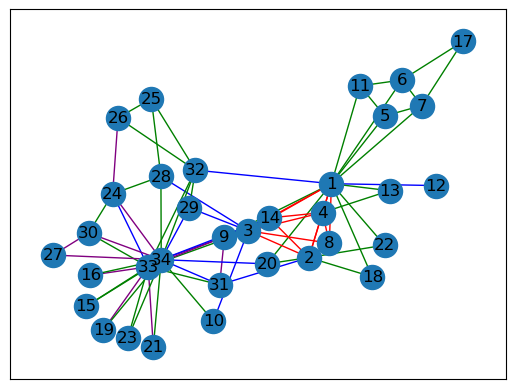

In [37]:
color_dict = {5:"red", 4:"purple", 3:"green", 2:"blue"}
edge_color = []

for i in range(G.size()):
    edge_color.append(color_dict[td[i]])
    
pos = nx.spring_layout(nx_display, seed=200)
nx.draw_networkx(nx_display, pos, with_labels=True, edge_color=edge_color)
plt.show()

### **Triangle Centrality**

Triangle centrality is a centrality measure to decide how important a vertex is based off how many triangles surround a particular vertex. It is calculated based off the following formula as seen in the paper titled "Triangle Centrality" by Paul Burkhardt.

$$TC(v) = \frac{\frac{1}{3} \sum_{u \in N_{\Delta}^{+}(v)}{\Delta(u)} + \sum_{w \in (N(v) \backslash N_{\Delta}(v))} {\Delta (w)}}{\Delta(G)}$$

Where $N(v)$ is the neighborhood set of a vertex $v$, $N_{\Delta}(v)$ is the set of neighbors that are in triangles with $v$, and $N_{\Delta}^{+}$ is the closed set that includes $v$. There is not an equivalent metric of this form available in NetworkX.

In [38]:
tce = ar.triangle_centrality(G)
print(f"One of the most important vertices in the graph is: {G.nodes()[ak.argmax(tce)]}")

One of the most important vertices in the graph is: 14


### **Subgraph Isomorphism**

The problem of motif finding in graphs is one of pattern matching with a smaller subgraph to search inside of a larger host graph. Here, we have an implementation of parallel VF2 that returns the subgraph mappings of vertices inside of the graph that contain the same structure as the given subgraph. Currently, our subgraph isomorphism method works only for property graphs. Further, it returns monomorphisms.

In [39]:
G_directed = ar.PropGraph()
edges_to_add = G.edges()
G_directed.add_edges_from(edges_to_add[0], edges_to_add[1])

In [40]:
subgraph = ar.PropGraph()
src = [0, 1, 2, 1]
dst = [1, 2, 0, 3]
subgraph.add_edges_from(ak.array(src), ak.array(dst))

In [41]:
isos = ar.subgraph_isomorphism(G_directed, subgraph)

In [42]:
print(f"We found {len(isos)/4} triangles with tails inside of the karate graph")

We found 1848.0 triangles with tails inside of the karate graph


### **Diameter**

The diameter of a graph is the longest of the shortest paths between two vertices in a graph. Here, we should an experimental version that approximates the diameter with connected components.

In [43]:
di = ar.diameter(G)
print(f"The diameter of karate is {di}") 

The diameter of karate is 4
